# Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Flatten

# Read data from csv file

In [5]:
data = pd.read_csv('Reliance.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-18,463.799988,465.649994,454.975006,456.000000,436.671021,5142766.0
1,2015-11-19,459.450012,469.350006,458.625000,467.375000,447.563873,5569752.0
2,2015-11-20,467.000000,476.399994,462.774994,473.424988,453.357422,5167930.0
3,2015-11-23,475.000000,478.950012,473.100006,476.875000,456.661224,4800026.0
4,2015-11-24,476.500000,485.799988,475.524994,483.850006,463.340515,6768886.0


# Drop rows with any null values

In [6]:
data.dropna(axis = 0, inplace = True)

# Check shape of the data

In [7]:
del data['Adj Close']
data.shape

(1232, 6)

# Copy dataset into new dataframe for plots

In [8]:
meta = data.copy()
meta['Date'] = pd.to_datetime(meta['Date'], format='%Y-%m-%d')
meta['Year'] = meta['Date'].dt.year
meta.head()

,Date,Open,High,Low,Close,Volume,Year
0,2015-11-18,463.799988,465.649994,454.975006,456.000000,5142766.0,2015
1,2015-11-19,459.450012,469.350006,458.625000,467.375000,5569752.0,2015
2,2015-11-20,467.000000,476.399994,462.774994,473.424988,5167930.0,2015
3,2015-11-23,475.000000,478.950012,473.100006,476.875000,4800026.0,2015
4,2015-11-24,476.500000,485.799988,475.524994,483.850006,6768886.0,2015


# Line plot of Close Price vs Year

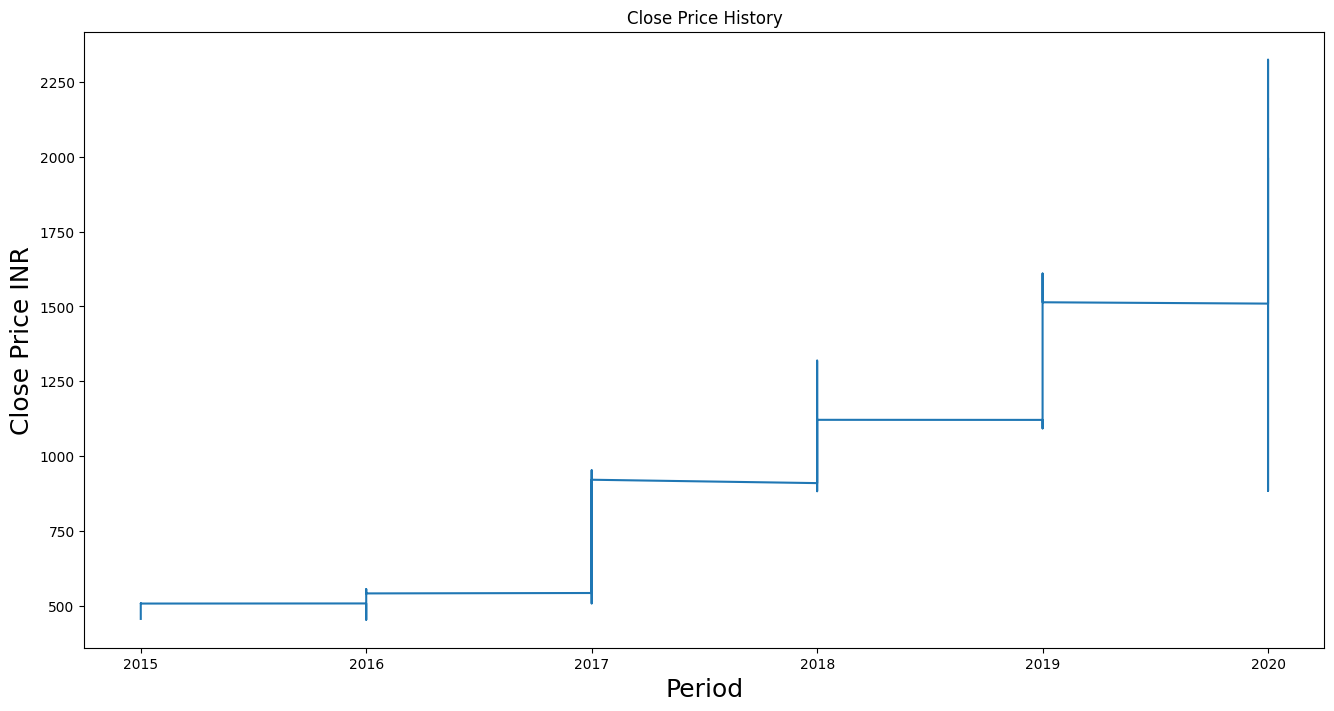

In [9]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(meta['Year'],meta['Close'])
plt.xlabel('Period', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

# Distribution of Close Price on day basis

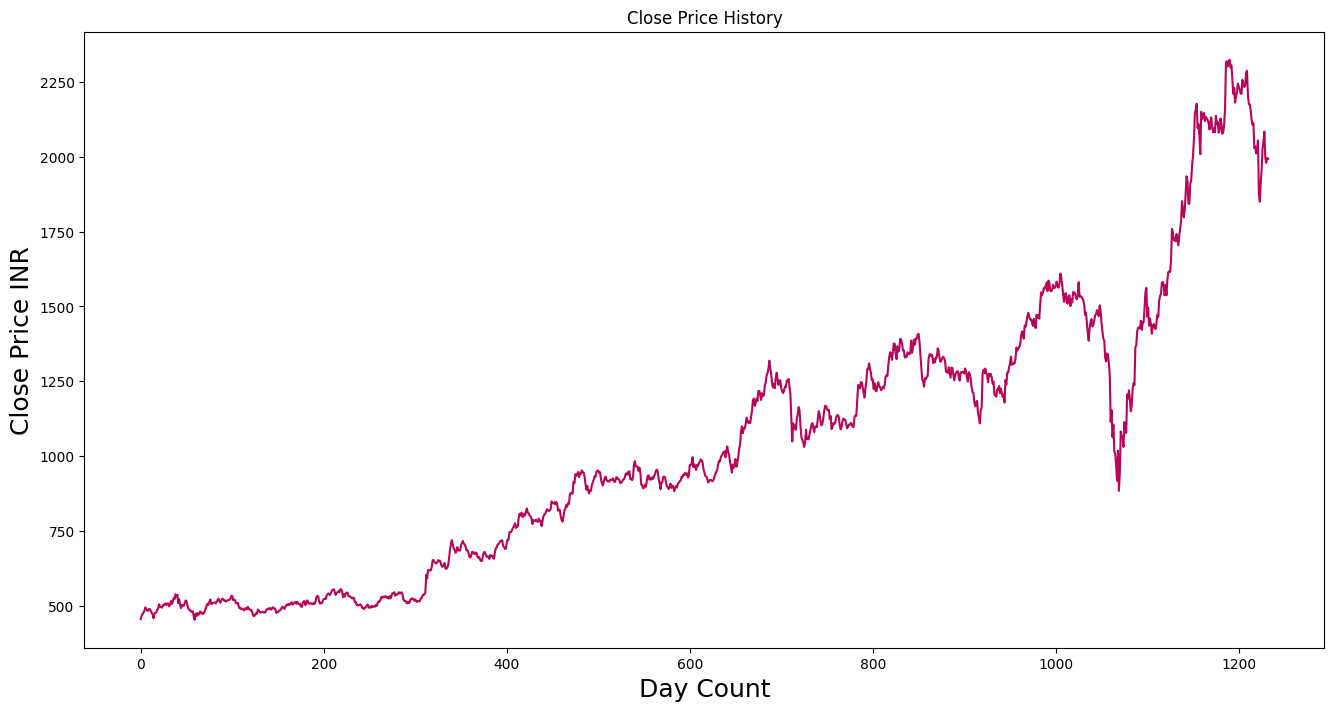

In [10]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(meta['Close'], color = '#ba0459')
plt.xlabel('Day Count', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

# Scatter plot of Volume Traded vs Year

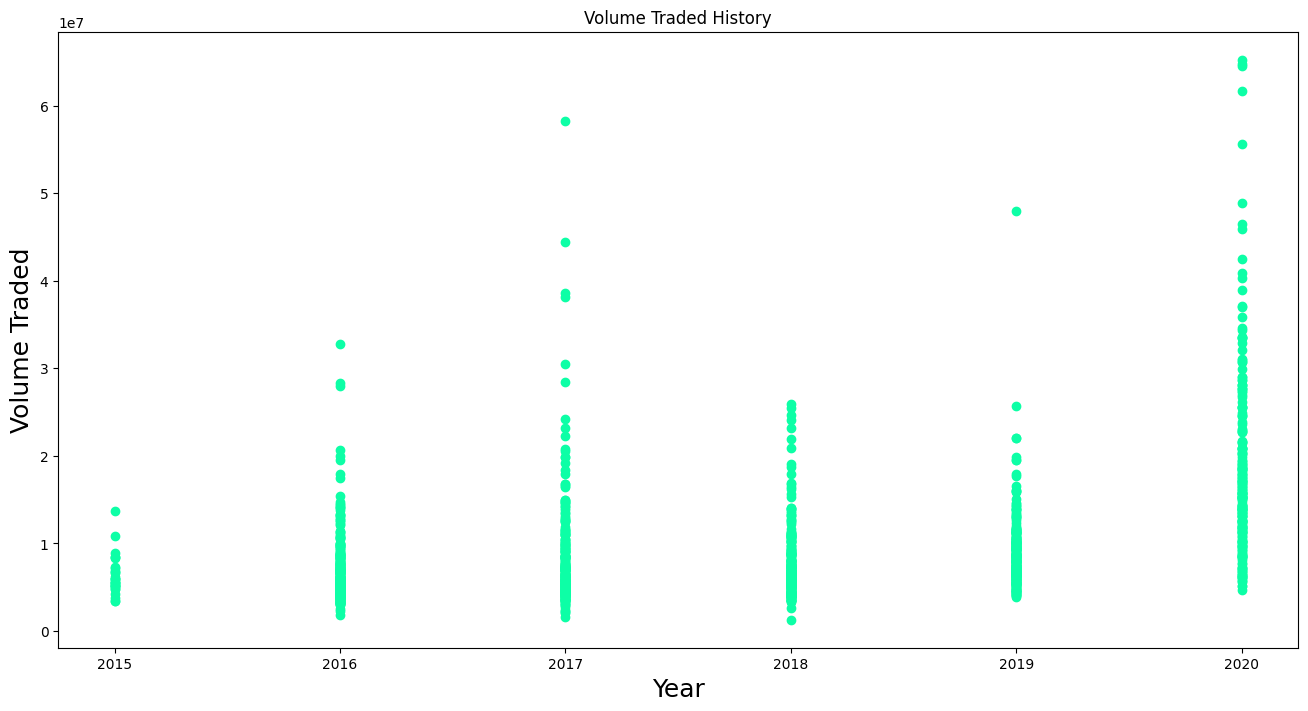

In [11]:
plt.figure(figsize=(16,8))
plt.title('Volume Traded History')
plt.scatter(x = meta['Year'], y = meta['Volume'], color = '#0dffa6')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Volume Traded', fontsize=18)
plt.show()

# Distribution of Volume Traded on day basis

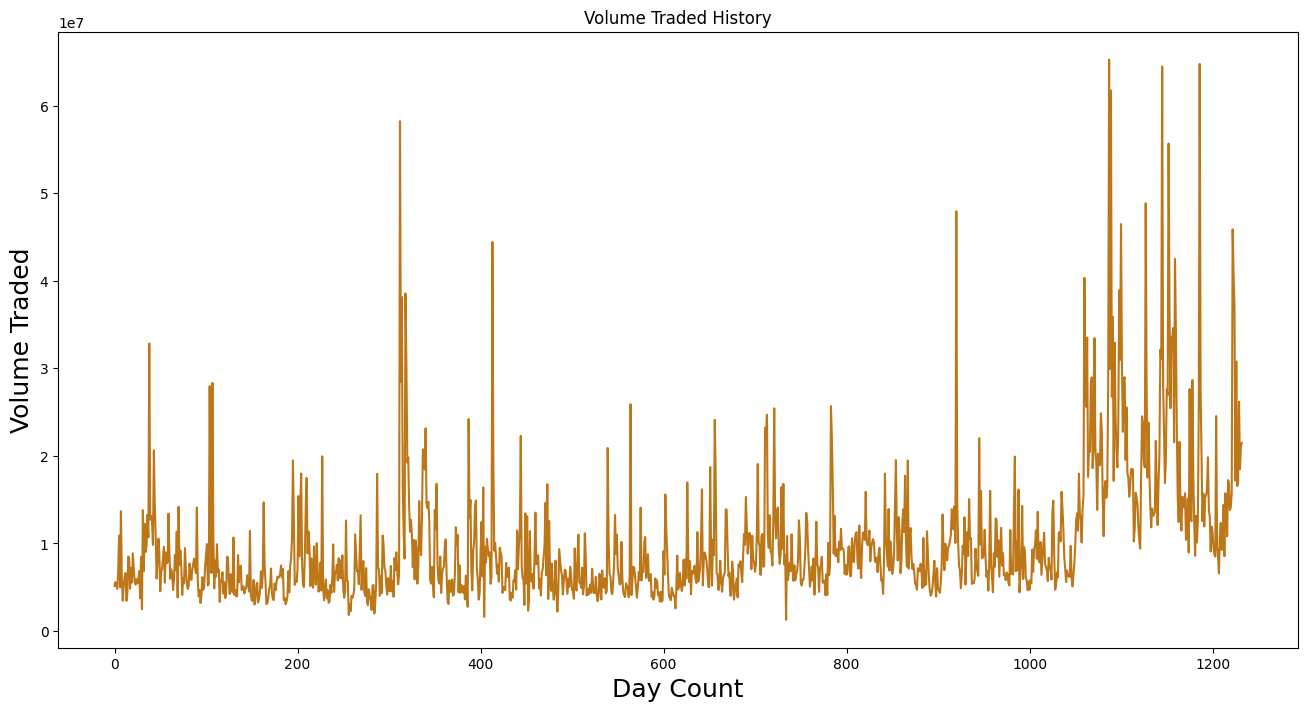

In [12]:
plt.figure(figsize=(16,8))
plt.title('Volume Traded History')
plt.plot(meta['Volume'], color = '#bd7719')
plt.xlabel('Day Count', fontsize=18)
plt.ylabel('Volume Traded', fontsize=18)
plt.show()

# Reset index of original dataframe

In [13]:
data.set_index('Date', inplace = True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-11-18,463.799988,465.649994,454.975006,456.000000,5142766.0
2015-11-19,459.450012,469.350006,458.625000,467.375000,5569752.0
2015-11-20,467.000000,476.399994,462.774994,473.424988,5167930.0
2015-11-23,475.000000,478.950012,473.100006,476.875000,4800026.0
2015-11-24,476.500000,485.799988,475.524994,483.850006,6768886.0


# Scale and transform the target and features column using MinMaxScaler

In [14]:
x_scaler = MinMaxScaler()
X = data[['Open', 'Low', 'High', 'Volume']].copy()
X_scaled = x_scaler.fit_transform(X)

y = data['Close'].copy()
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))


# Function to split dataset into Train and Test dataset

In [15]:
def load_data(X, seq_len, train_size=0.8):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    datanew = []

    for index in range(len(X_mat) - sequence_length):
        datanew.append(X_mat[index: index + sequence_length])

    datanew = np.array(datanew)
    train_split = int(round(train_size * datanew.shape[0]))
    train_data = datanew[:train_split, :]

    X_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]

    X_test = datanew[train_split:, :-1]
    y_test = datanew[train_split:, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return X_train, y_train, X_test, y_test

# Initializing the above function with a lookback window of 22

In [16]:
window = 22
X_scaled_df = pd.DataFrame(X_scaled, columns=['Open', 'Low', 'High', 'Volume'])
X_scaled_df['close'] = y_scaled

X_train, y_train, X_test, y_test = load_data(X_scaled_df, window)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(967, 22, 5)
(967,)
(242, 22, 5)
(242,)


# Building our CNN(1D)+LSTM model to make predictions

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, LSTM


model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window, 5)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=16, callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0152 - val_loss: 0.0099
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0071
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0059


# Check *RMSE* of Train and Test dataset

In [18]:
from sklearn.metrics import mean_squared_error, r2_score


trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)


trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])


trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))


trainR2 = r2_score(trainY[0], trainPredict[:,0])
testR2 = r2_score(testY[0], testPredict[:,0])

print('Train Score: %.2f RMSE, %.2f R²' % (trainScore, trainR2))
print('Test Score: %.2f RMSE, %.2f R²' % (testScore, testR2))

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Train Score: 41.22 RMSE, 0.98 R²
Test Score: 131.11 RMSE, 0.87 R²


In [19]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(242, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(242, 1)

plot_predicted_train = trainPredict.copy()
plot_predicted_train = plot_predicted_train.reshape(967, 1)
plot_actual_train = trainY.copy()
plot_actual_train = plot_actual_train.reshape(967, 1)

# Predictions on Train dataset

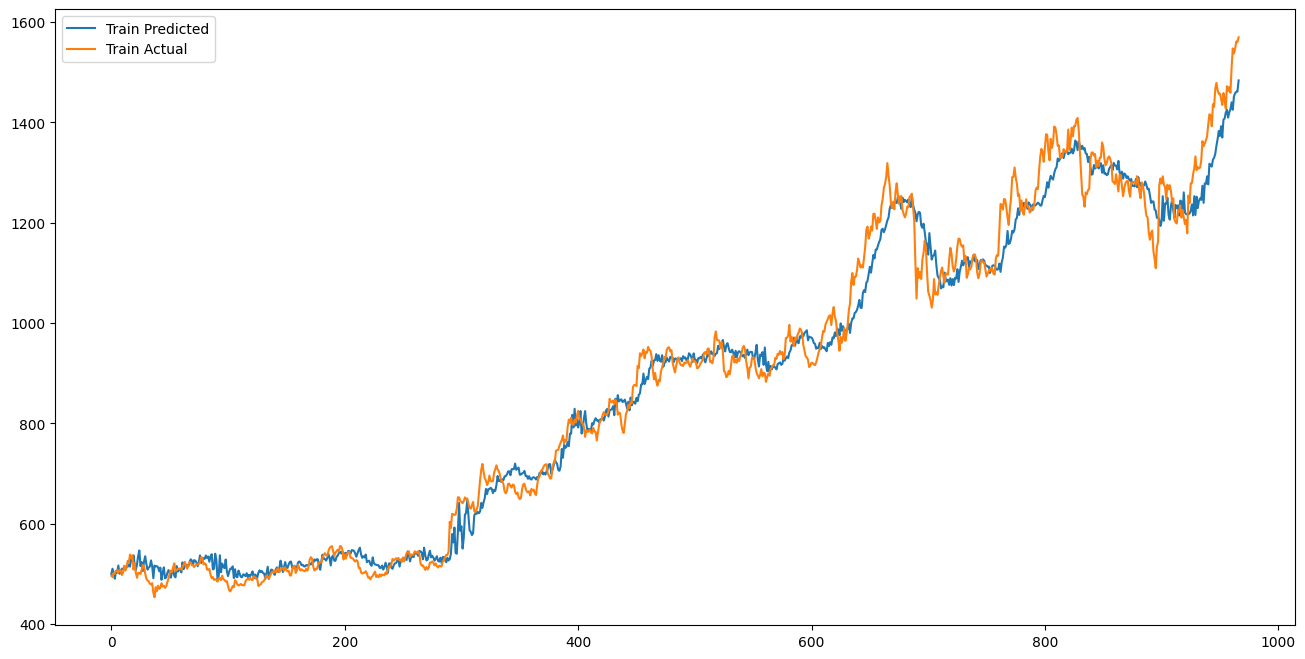

In [20]:
plt.figure(figsize = (16,8))
plt.plot(pd.DataFrame(plot_predicted_train), label='Train Predicted')
plt.plot(pd.DataFrame(plot_actual_train), label='Train Actual')
plt.legend(loc='best')
plt.show()

# Predictions on Test dataset

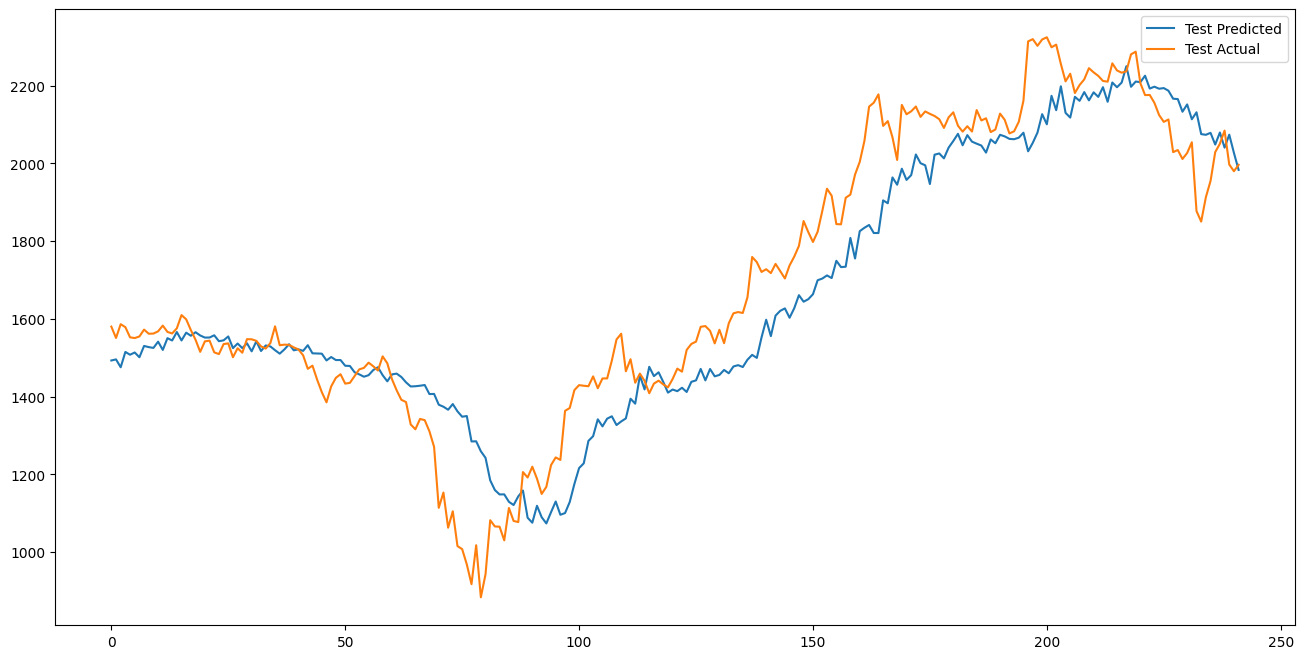

In [21]:
plt.figure(figsize = (16,8))
plt.plot(pd.DataFrame(plot_predicted), label='Test Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Test Actual')
plt.legend(loc='best')
plt.show()